In [112]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [113]:
import sqlite3

connection = sqlite3.connect("file:db/words.db?mode=ro")

In [114]:
username = 'stormalinblue'
user_id = connection.execute('select id from users where users.user_name = ?', (username,)).fetchone()[0]

In [115]:
import lib.game.model as gamemodel
from lib.common.util import utc_now_sec_timestamp

In [116]:
import pandas as pd
import numpy as np
import scipy

In [117]:
word_weight_table = gamemodel.word_weight_table(connection, user_id, utc_now_sec_timestamp())
word_pos_definitions = pd.read_sql(
    '''
select
    word_pos.id as word_pos_id, words.word as word, parts_of_speech.name as pos
from
    word_parts_of_speech as word_pos
    join words on words.id = word_pos.word_id
    join parts_of_speech on parts_of_speech.id == word_pos.part_of_speech_id''',
    con=connection,
    index_col=['word_pos_id']
)

word_table = pd.concat([word_pos_definitions, word_weight_table], axis=1)

Text(0.5, 1.0, 'PDFs for beta distributions for the top 5 words')

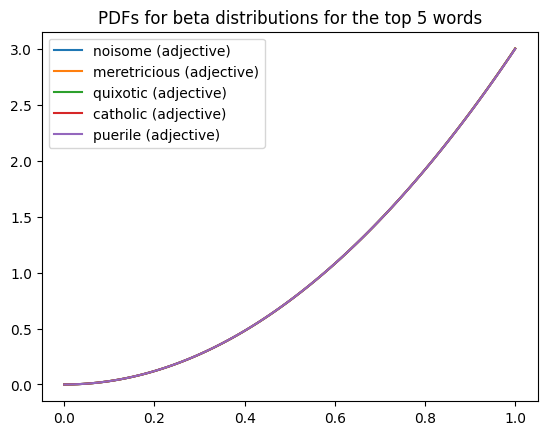

In [118]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

x_axis = np.linspace(0, 1, 100)

n_highest = 5
word_table['mean_prob'] = (word_table['correct']) / (word_table['correct'] + word_table['incorrect'])
highest = word_table.sort_values('mean_prob', ascending=False).head(n_highest)
for word_pos_id, row in highest.iterrows():
    ax.plot(x_axis, scipy.stats.beta(row.correct, row.incorrect).pdf(x_axis), label=f'{row.word} ({row.pos})')

ax.legend()
ax.set_title(f'PDFs for beta distributions for the top {n_highest} words')

Text(0.5, 1.0, 'PDFs for beta distributions for the bottom 5 words')

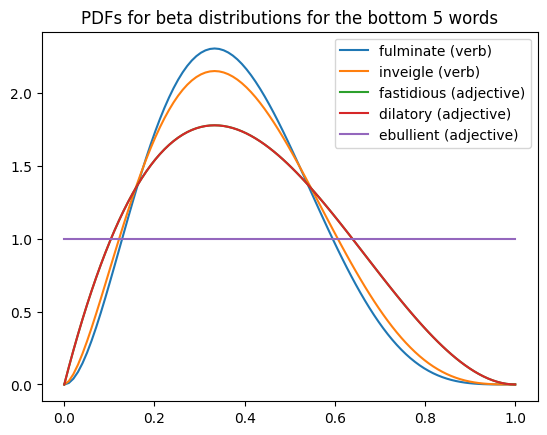

In [119]:
fig, ax = plt.subplots()
lowest = word_table.sort_values('mean_prob', ascending=True).head(n_highest)
for word_pos_id, row in lowest.iterrows():
    ax.plot(x_axis, scipy.stats.beta(row.correct, row.incorrect).pdf(x_axis), label=f'{row.word} ({row.pos})')

ax.legend()
ax.set_title(f'PDFs for beta distributions for the bottom {n_highest} words')

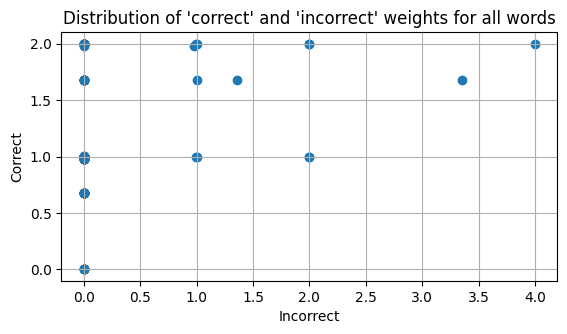

In [123]:
fig, ax = plt.subplots()

ax.set_xlabel('Incorrect')
ax.set_ylabel('Correct')
ax.set_title("Distribution of 'correct' and 'incorrect' weights for all words")
ax.grid(True)
ax.scatter(word_table['incorrect'] - 1, word_table['correct'] - 1)
ax.set_aspect(1)

Text(0, 0.5, 'Num words')

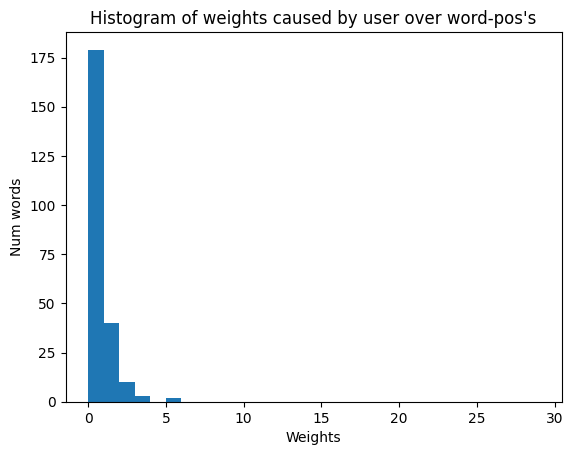

In [121]:
fig, ax = plt.subplots()

ax.hist(word_table['correct'] + word_table['incorrect'] - 2, bins=range(30))
ax.set_title('Histogram of weights caused by user over word-pos\'s')
ax.set_xlabel('Weights')
ax.set_ylabel('Num words')

Text(0, 0.5, 'Number of words')

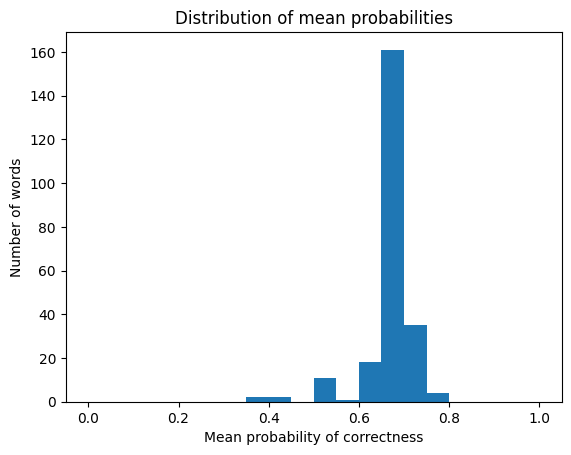

In [122]:
fig, ax = plt.subplots()

ax.hist(word_table['mean_prob'], range=(0, 1), bins=20)
ax.set_title('Distribution of mean probabilities')
ax.set_xlabel('Mean probability of correctness')
ax.set_ylabel('Number of words')